In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Range of X: {X.min()} ~ {X.max()}")
    break


Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Range of X: 0.0 ~ 1.0


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
CODEBOOK_SIZE = 30

class ResidualBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)   # 3x3 same size filtering
        self.bn = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)  # 3x3 same size filtering

    def forward(self, inp):
        x = self.conv1(inp)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + inp
        
# Encoder model
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.ReLU(),
        )
        self.residual_pool_stack2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            ResidualBlock(32),
            nn.AvgPool2d(2)                               # Downsampling 2x2
        )
        self.residual_pool_stack3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            ResidualBlock(64),
            nn.AvgPool2d(2)                              # Downsampling 2x2
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 8, bias=False)
        )
    
    def forward(self, x):
        x = self.conv_stack1(x)
        x = self.residual_pool_stack2(x)
        x = self.residual_pool_stack3(x)
        x = self.linear_relu_stack(x)
        return x
        
# Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_reverse_stack = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 7*7*64)
        )

        self.residual_upsample_stack1 = nn.Sequential(
            nn.Upsample(scale_factor=2),                           # Upsampling 2x2
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            ResidualBlock(32),
        )

        self.residual_upsample_stack2 = nn.Sequential(
            nn.Upsample(scale_factor=2),                           # Upsampling 2x2
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            ResidualBlock(8),
            ResidualBlock(8),
        )
        self.reverse_conv_stack = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1, padding=0),   # 3x3 same size filtering
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.Sigmoid()
        )
    
    
    def forward(self, x):
        y = self.linear_reverse_stack(x)
        batch_size = y.shape[0]
        y = y.reshape(batch_size, 64, 7, 7) 
        y = self.residual_upsample_stack1(y)
        y = self.residual_upsample_stack2(y)
        y = self.reverse_conv_stack(y)
        return y

class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Parameter(torch.rand(CODEBOOK_SIZE, 8))
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        rep = self.encoder(x)
        y = self.decoder(rep)
        return y

model = VQVAE().to(device)
print(model)

Using mps device
VQVAE(
  (encoder): Encoder(
    (conv_stack1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (residual_pool_stack2): Sequential(
      (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stri

In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()))
optimizer_code = torch.optim.SGD([model.emb], lr=0.001)

In [6]:
def train(dataloader, model, loss_fn, optimizer, refresh_code = False):
    size = len(dataloader.dataset)
    model.train()
    if refresh_code:
        X, y = next(iter(dataloader))
        X = X.to(device)
        with torch.no_grad():
            model.emb.data = model.encoder(X)[:model.emb.shape[0]]

    for batch, (X, y) in enumerate(dataloader):
        X, _cat = X.to(device), y.to(device)
        # Compute autoencoder error
        rep = model.encoder(X)
        rep.retain_grad()
        emb_d = model.emb.detach()
        rep_d = rep.detach()
        batch_size = rep_d.shape[0]
        code_size = emb_d.shape[0]
        scores = torch.sum(rep_d ** 2, dim=-1, keepdim=True).repeat(1, CODEBOOK_SIZE) + torch.sum(emb_d ** 2, dim=-1).repeat(X.shape[0], 1) -2.0 * torch.matmul(rep_d, emb_d.transpose(0, 1))
        assignment = scores.argmin(axis=-1)
        
        rep_vectorized = model.emb[assignment, :]
        rep_vectorized.retain_grad()
        X_reconstructed = model.decoder(rep_vectorized)
        X_rec2 = model.decoder(rep)
        emb_assigned = model.emb[assignment, :]

        # loss to update codebook
        code_loss = loss_fn(emb_assigned, rep_d)
        # reconstruction loss with respect to code embeddings
        loss_reconstruction = loss_fn(X, X_reconstructed)
        # reconstruction loss with respect to original input (not in original paper, add this one for stablizing training)
        loss_rec2 = loss_fn(X, X_rec2)
        # commitment loss
        loss_rep = loss_fn(rep, rep_vectorized)

        #total loss
        loss = loss_reconstruction + 0.25 * loss_rep + code_loss  + loss_rec2
        # Backpropagation
        loss.backward()
        # Propagate the gradients of code embedding to the encoder. 
        rep.grad += rep_vectorized.grad
        
        optimizer.step()
        optimizer_code.step()
        optimizer.zero_grad()
        optimizer_code.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            loss_r, loss_e = loss_reconstruction.item(), loss_rep.item()
            print(f"loss: {loss:>7f} (r={loss_r:>5f}, e={loss_e:>5f}  [{current:>5d}/{size:>5d}]")
            print(assignment)


In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _cat in dataloader:
            X = X.to(device)
            rebuild = model(X)
            test_loss += loss_fn(X, rebuild).item()
    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")

In [8]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Refresh the codebook at the first two epochs to initialize with proper scale
    # We can re-do the refresh if encountering code collapse
    train(train_dataloader, model, loss_fn, optimizer, refresh_code=(t<2))
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.409306 (r=0.204261, e=0.000627  [  128/60000]
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 23,  2, 10, 26,  2, 28,
        12, 28, 25, 24, 18, 14, 15, 13, 15, 10,  6, 22,  1, 25, 21, 20,  0,  7,
        28, 10, 17, 22, 20, 24,  9,  3, 13, 23, 25, 18, 17, 25, 28, 21, 24, 22,
         2, 20, 25, 25, 17, 10, 21, 15, 21, 28, 14,  6, 14, 12, 21, 14,  0,  9,
        14, 20, 28, 15, 22,  2,  2, 25, 22, 12, 16, 22,  4,  4, 23,  6, 21,  0,
        14,  9,  8, 14, 10, 22,  3,  2,  8, 29, 28, 14, 13, 14,  9, 28, 29, 28,
         6,  2], device='mps:0')
loss: 0.131037 (r=0.070703, e=0.000877  [12928/60000]
tensor([17, 18, 22,  2, 18, 18, 28, 18,  2,  2,  1, 25, 18, 18, 25, 10, 16,  1,
        16, 22,  2, 16, 18, 22, 28, 16, 25, 25, 10, 16, 16,  1, 20, 22, 22, 28,
        18, 10, 10,  1, 16, 22,  2, 25, 28, 18, 22, 16, 18, 25, 28, 10, 22, 22,
        16, 20,  2,

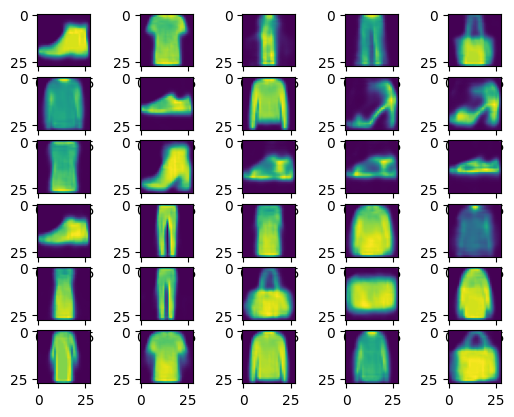

In [9]:
import matplotlib.pyplot as plt

def codebook_visualize(model):
    model.eval()
    with torch.no_grad():
        rebuild = model.decoder(model.emb)
        rebuild_np = rebuild.cpu().numpy()
        codebook_row = (rebuild.shape[0]+4) // 5
        fig, axs = plt.subplots(codebook_row, 5)
        for i in range(codebook_row):
            for j in range(5):
                axs[i, j].imshow(rebuild_np[i*5 + j][0])
        plt.show()
codebook_visualize(model)

In [10]:
import matplotlib.pyplot as plt

def test_with_assignment(model, dataset, n=10):
    model.eval()
    counter = 0
    dataloader = DataLoader(test_data, batch_size=1)
    with torch.no_grad():
        code_rebuild = model.decoder(model.emb)
        code_rebuild_np = code_rebuild.cpu().numpy()[:, 0, :, :]
        for X, y in dataloader:
            Xd = X.to(device)
            rep = model.encoder(Xd)
            emb_d = model.emb
            scores = torch.sum(rep ** 2, dim=-1, keepdim=True).repeat(1, CODEBOOK_SIZE) + torch.sum(emb_d ** 2, dim=-1).repeat(X.shape[0], 1) -2.0 * torch.matmul(rep, emb_d.transpose(0, 1))
            assignment = scores.argmin(axis=-1).item()
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(X[0,0].numpy())
            ax1.set_title("Original input")
            ax2.imshow(code_rebuild_np[assignment])
            ax2.set_title(f"Code: {assignment}")
            plt.show()
            counter +=1
            if counter > n:
                break

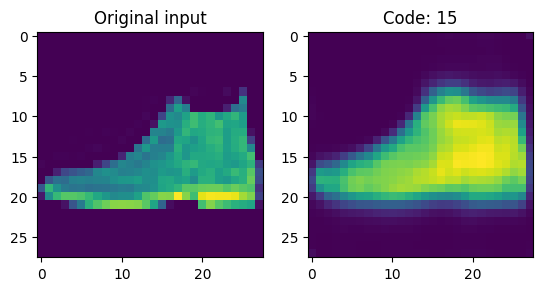

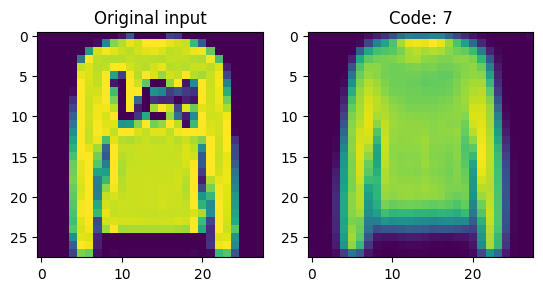

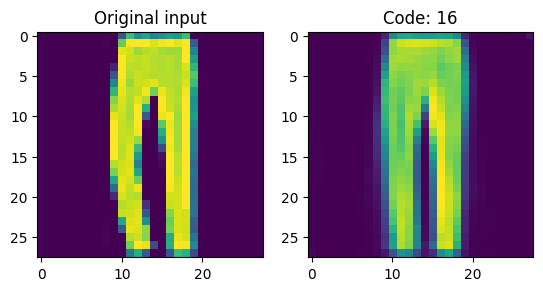

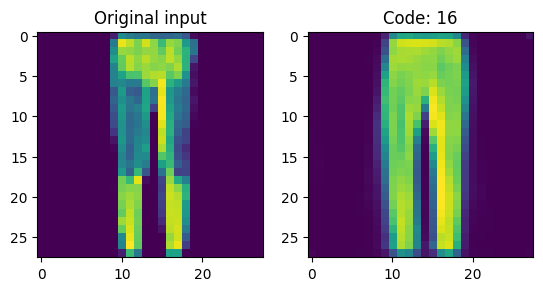

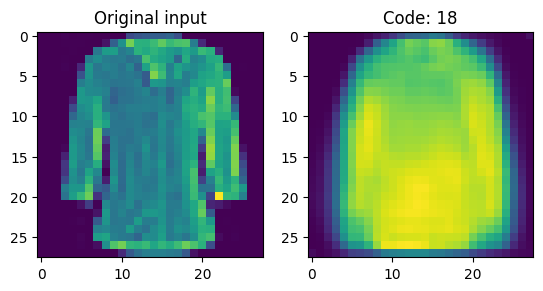

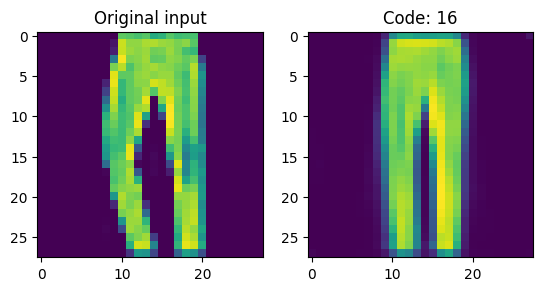

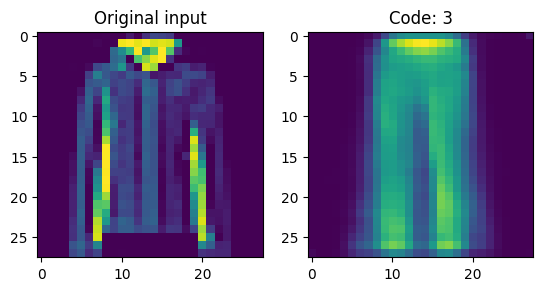

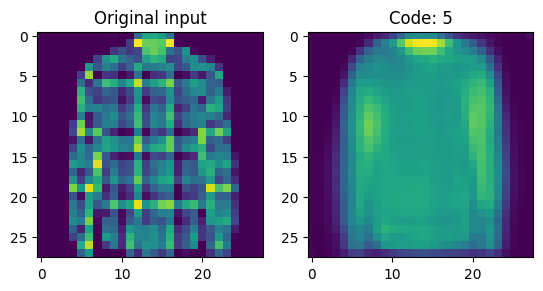

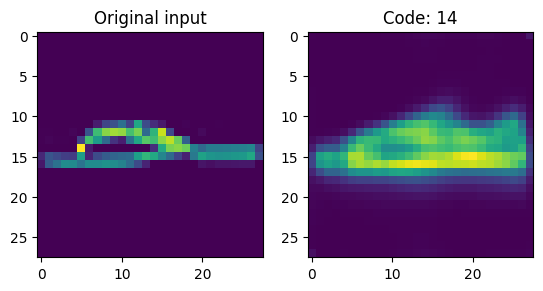

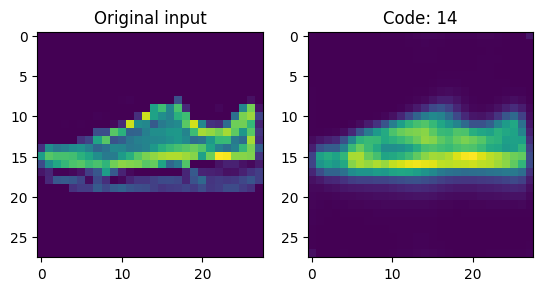

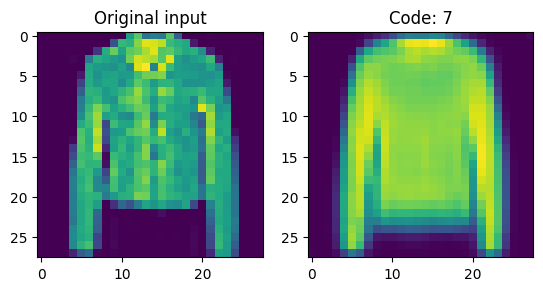

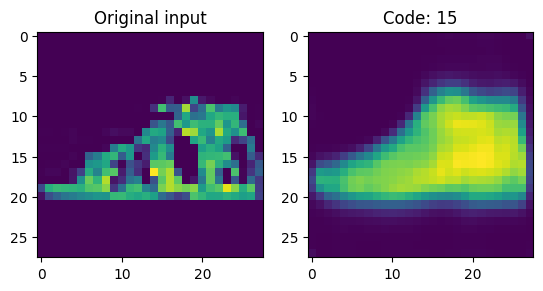

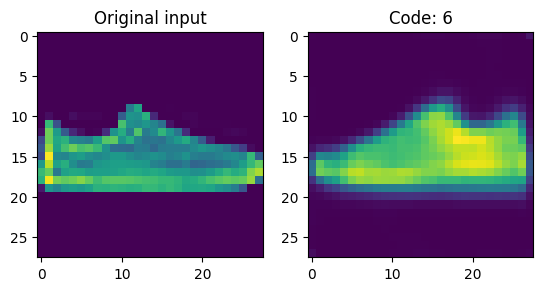

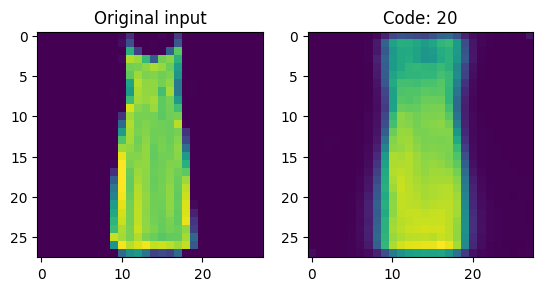

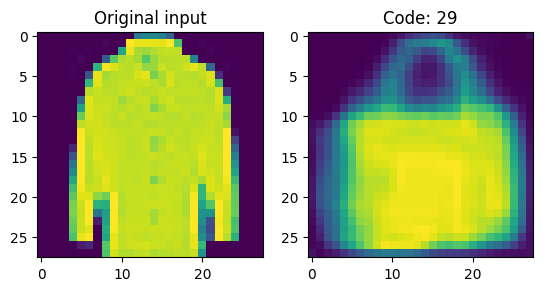

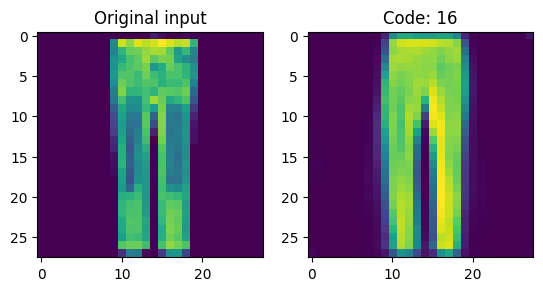

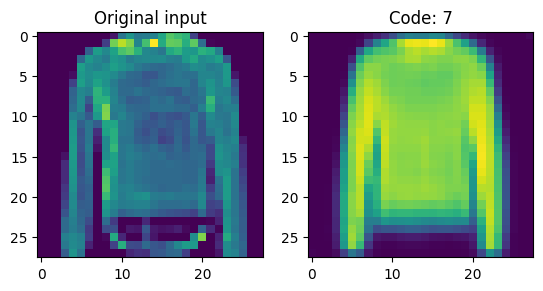

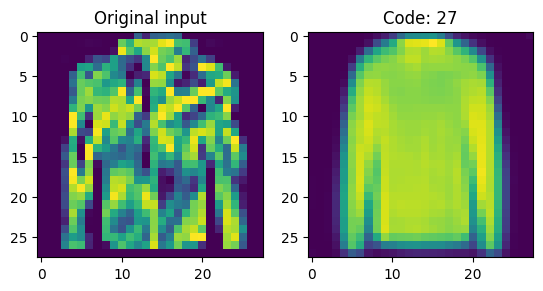

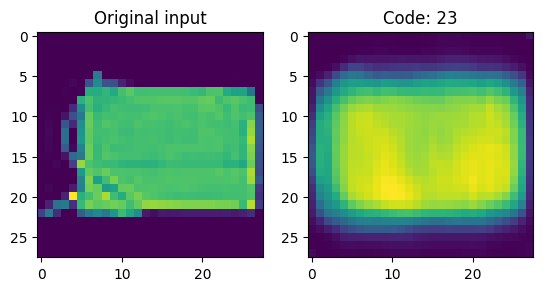

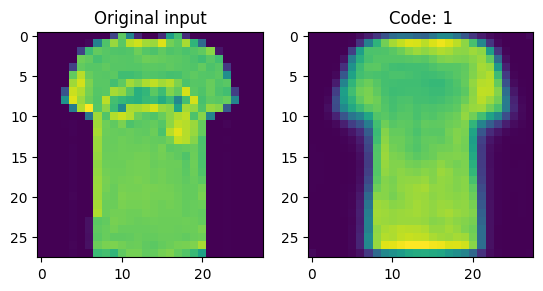

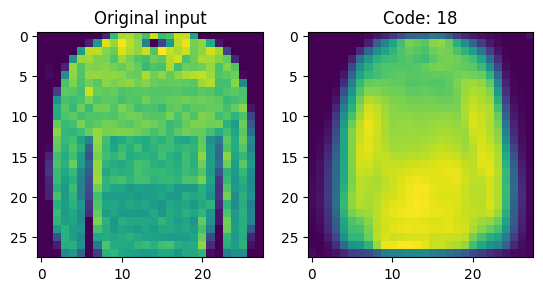

In [11]:
test_with_assignment(model, test_data, 20)